# 1. Set the US, CS inputs


In [40]:
import numpy as np
import matplotlib.pyplot as plt

trial_length = 30
conditioning_length = 15

extinction_length = 15
cs = np.ones(30)
us1 = np.ones((1,15))
us2 = np.zeros((1,15))
us = np.hstack((us1,us2))
cs = np.squeeze(cs)
us = np.squeeze(us)
timesteps = np.arange(30)


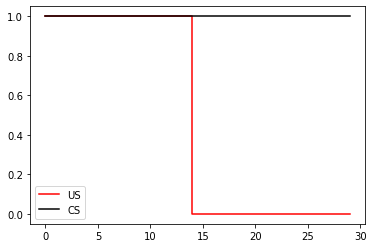

In [41]:
plt.step(timesteps,us,'r',label='US')
plt.step(timesteps,cs,'k',label = 'CS')
plt.legend()
plt.show()


# 2. Rescorla-Wagner model 
$W_{n+1} = W_n + \Delta W\\
\Delta W= \alpha  \text{CS}  (\text{US}_n- \hat{\text{US}}_n) \\
\hat{\text{US}}_n = W_{n}\text{CS}_n$

**If follow Gershman's notation:**
$\mathbf{w}_{n+1}=\mathbf{w}_n+\alpha x_n \delta_n\\
\mathbf{v}_n = \mathbf{w}_n^Tx_n\\
\delta_n = r_n-\mathbf{v}_n$



In [42]:
def rw(cs,us,alpha = 0.2):
    n = len(cs)
    w = np.zeros(n)
    estimated_us = np.zeros(n)
    for i in range(n-1):
        dw = alpha*cs[i]*(us[i]-w[i]*cs[i])
        w[i+1] = w[i]+dw
        estimated_us[i+1] = w[i+1]*cs[i+1]
    return w,estimated_us
    

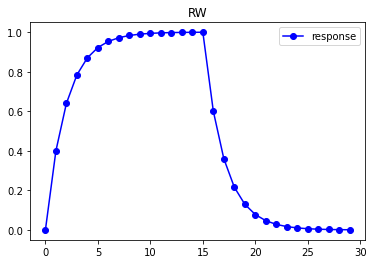

In [43]:
w,estimated_us_rw = rw(cs,us,alpha=0.4)

#plt.plot(t,w,label='w')
plt.plot(timesteps,estimated_us_rw,'bo-',label='response')
plt.legend()
plt.title('RW')
plt.show()

# 3. TD model
$W_{n+1} = W_n + \Delta W\\
\delta_n = \text{US}_n+\gamma W_{n} \text{CS}_{n+1}-W_n \text{CS}_n\\
\Delta W= \alpha  \text{CS}  \delta_n\\
\hat{\text{US}}_n = W_{n}\text{CS}_n$

**If follow Gershman's notation:**
$ \mathbf{\hat w}_{t+1} =\mathbf{\hat w}_t + \alpha x_t \delta_t\\
\delta_t = r_t + \gamma\mathbf{\hat w}_{t}^T x_{t+1}-\mathbf{\hat w}_t^T x_t \\
\mathbf{v}_t = \mathbf{w}_t^T x_t$

In [44]:
def td(x,r,alpha=0.2,gamma=0.8):
    N = len(x)
    w = np.zeros(N)
    v = np.zeros(N)
    sigma = np.zeros(N)
    for t in range(N-1):
        sigma[t] = r[t] + gamma*w[t+1]*x[t+1]-w[t]*x[t]
        w[t+1] = w[t] + alpha*x[t]*sigma[t]
        v[t+1] = w[t+1]*x[t+1]
    return w,v


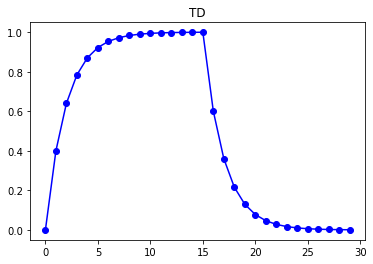

In [45]:
w,estimated_us_td = td(cs,us,alpha=0.4,gamma=0.8)
timesteps = np.arange(len(cs))
#plt.plot(timesteps,w)
plt.plot(timesteps,estimated_us_td,'bo-')
plt.title('TD')
plt.show()

# 4. RW model with Kalman Filter

##  A linear-Gaussian dynamical system (LDS)
$\mathbf{w}_0 \sim \mathcal{N}(0,\sigma_w^2 \mathbf{I})\\
\mathbf{w}_n \sim \mathcal{N}(\mathbf{w}_{n-1},\tau^2\mathbf{I})\\
\hat r_n \sim \mathcal{N}(v_n, \sigma_r^2)$

## Robbins-Monro algorithm for stochastic approximation
$\hat{\mathbf{w}}_{n+1}= \hat{\mathbf{w}}_n+\alpha_n \sigma^{-2}x_n(r_n-x_n)$

where $\alpha$ is dynamically decreasing, so that: 
$\sum_n \alpha_n = \infty, \sum_n \alpha_n^2 <\infty$ 

One simple choice of learning rate that satisfies these conditions is $\alpha_n = \frac{1}{n}$

## Bayesian inference and Kalman Filter  in associative learning 
$P(\mathbf{w}_n|x_{1:n})\propto P(x_{1:n}|\mathbf{w}_n)P(\mathbf{w}_n)$

The posterior Gaussian distribution of $\mathbf{w}_n $ with mean $\mathbf{\hat{w}}_n$ and covariance $\Sigma_n$, can be updated by Kalman Filter: 

$\mathbf{\hat{w}}_{n+1} = \mathbf{\hat w}_n+k_n\delta_n\\
\Sigma_{n+1} = \Sigma_n+\tau^2 \mathbf{I} -k_nx_n^T(\Sigma_n+\tau^2\mathbf{I})\\
\mathbf{v}_n = \mathbf{w}_n^Tx_n\\
\delta_n = r_n-\mathbf{v}_n$

where, 
$k_n = \frac{(\Sigma_n+\tau^2\mathbf{I})x_n}{x^T_n(\Sigma_n+\tau^2\mathbf{I})x_n+\sigma^2_r},\\
\mathbf{\hat w}_0 =0, \Sigma_0 = \sigma^2_w\mathbf{I}$

In [46]:
def krw(x,r,sigma_w =1, sigma_r=1,tau=0.3):
    N = len(x)
    w = np.zeros(N)
    Sigma = np.zeros(N)
    Sigma[0]=sigma_w**2
    w = np.zeros(N)
    v = np.zeros(N)
    delta = np.zeros(N)
    k = np.zeros(N)
    for n in range(N-1):
        v[n] = x[n]*w[n]
        delta[n] = r[n]-v[n]
        k[n] = (Sigma[n]+tau**2)*x[n]/(x[n]*(Sigma[n]+tau**2)*x[n]+sigma_r**2)
        w[n+1] = w[n] + k[n]*delta[n]
        Sigma[n+1]=Sigma[n]+tau**2-k[n]*x[n]*(Sigma[n]+tau**2)
    v[N-1] = x[N-1]*w[N-1]
    return w,v
    

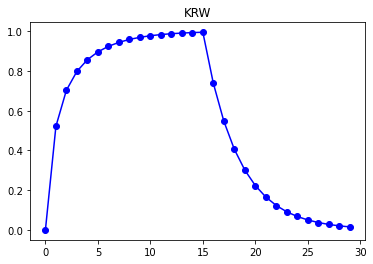

In [47]:
w,estimated_us_krw = krw(cs,us,sigma_w =1, sigma_r=1,tau=0.3)
plt.plot(estimated_us_krw,'bo-')
plt.title('KRW')
plt.show()


# 5. TD model with Kalman Filter
$\mathbf{v}_t = \mathbf{\hat{w}}_t^T x_t\\
\mathbf{\hat{w}}_{t+1} = \mathbf{\hat w}_t+k_t\delta_t\\
\delta_t = r_t+\gamma \mathbf{\hat{w}}_t^T x_{t+1} - \mathbf{\hat{w}}_t^T x_t\\
h_t=\gamma x_{t+1}-x_t\\
k_t = \frac{(\Sigma_t+\tau^2\mathbf{I})h_t}{h^T_t(\Sigma_n+\tau^2\mathbf{I})h_t+\sigma^2_r},\\
\Sigma_{t+1} = \Sigma_t+\tau^2 \mathbf{I} -k_th_t^T(\Sigma_t+\tau^2\mathbf{I})\\
\mathbf{\hat w}_0 =0, \Sigma_0 = \sigma^2_w\mathbf{I}
$

In [48]:
def ktd(x,r,sigma_w =1, sigma_r=1,tau=0.3,gamma = 0.2):
    N = len(x)
    w = np.zeros(N)
    Sigma = np.zeros(N)
    Sigma[0]=sigma_w**2
    w = np.zeros(N)
    v = np.zeros(N)
    delta = np.zeros(N)
    k = np.zeros(N)
    h = np.zeros(N)
    for t in range(N-1):
        v[t] = x[t]*w[t]
        delta[t] = r[t]+gamma*w[t]*x[t+1]-w[t]*x[t]
        h[t] = x[t]-gamma*x[t+1]
#         h[t] =x[t]
        k[t] = (Sigma[t]+tau**2)*h[t]/(h[t]*(Sigma[t]+tau**2)*h[t]+sigma_r**2)
        w[t+1] = w[t] + k[t]*delta[t]
        Sigma[t+1]=Sigma[t]+tau**2-k[t]*h[t]*(Sigma[t]+tau**2)
    v[N-1] = x[N-1]*w[N-1]
    return w,v
    

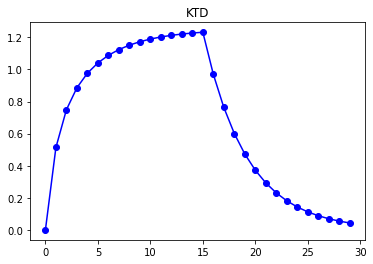

In [49]:
w,estimated_us_ktd = ktd(cs,us)
plt.plot(estimated_us_ktd,'bo-')
plt.title('KTD')
plt.show()

# II. Set to two reward-level 

## 1. Setup inputs CS, US

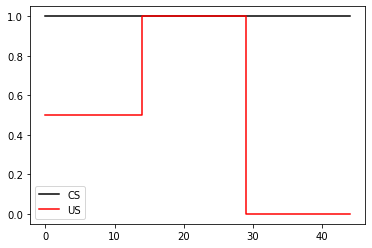

In [50]:
N = 45
cs = np.ones(N)
us1 = np.ones(15)*0.5
us2 = np.ones(15)
us3 = np.zeros(15)
us = np.hstack((us1,us2,us3))
plt.step(cs,'k',label='CS')
plt.step(us,'r',label='US')
plt.legend()
plt.show()

## 2. Simulation by RW, TD, KRW, KTD

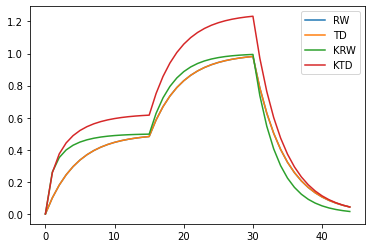

In [51]:
w_rw,v_rw = rw(cs,us)
w_td, v_td = td(cs,us)
w_krw,v_krw = krw(cs,us)
w_ktd,v_ktd = ktd(cs,us)

plt.plot(v_rw,label='RW')
plt.plot(v_td,label='TD')
plt.plot(v_krw,label='KRW')
plt.plot(v_ktd,label='KTD')
plt.legend()
plt.show()

# III. Change inputs 
## 1. Set US, CS

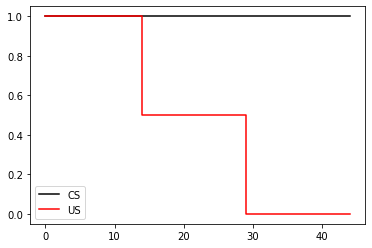

In [52]:
N = 45
cs = np.ones(N)
us1 = np.ones(15)
us2 = np.ones(15)*0.5
us3 = np.zeros(15)
us = np.hstack((us1,us2,us3))
plt.step(cs,'k',label='CS')
plt.step(us,'r',label='US')
plt.legend()
plt.show()

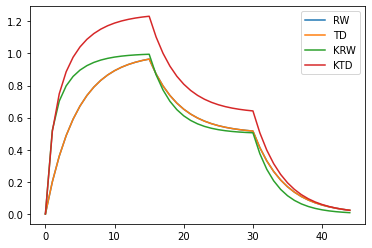

In [53]:
w_rw,v_rw = rw(cs,us)
w_td, v_td = td(cs,us)
w_krw,v_krw = krw(cs,us)
w_ktd,v_ktd = ktd(cs,us)

plt.plot(v_rw,label='RW')
plt.plot(v_td,label='TD')
plt.plot(v_krw,label='KRW')
plt.plot(v_ktd,label='KTD')
plt.legend()
plt.show()

## Pearce-Hall , time bin

# Bayesian Logistic Regerssion 

In [54]:
for i in range(len(us)-1):
    x = us[i]
    t = us[i]
    

us.shape

In [55]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
class BayesianLogisticRegression():
    def __init__(self,w0 = None,prior_variance = 1):
        self.w0 = w0
        self.prior_variance = prior_variance


    def log_prior(self, w,variance):
        return -1 / (2 * variance) * (w.T @ w)
    def log_likelihood(self,w,X, y):
        sigma = sigmoid(w.T @ X)
        return np.sum(y * np.log(sigma)+ (1 - y) * np.log(1 - sigma))

    def log_posterior(self, w, X, y):
        prior_variance = self.prior_variance
     
        return self.log_likelihood(w, X, y) + self.log_prior(w, prior_variance)

    def posterior_gradient(self,w, X, y):

        return X@(y - sigmoid(w.T @ X)) - w / self.prior_variance



    def find_w_map(self,X, y, w0=None):
        if len(X.shape) ==1:
            X = X.reshape((-1,1))
        # if len(y.shape) ==1:
        #     y = y.reshape((-1,1))
        from scipy.optimize import fmin_l_bfgs_b as minimise

        if w0 is None:
            # w0 = np.random.normal(size=X.shape[0])
            w0 = np.zeros(X.shape[0])+0.1
        w_map, *d = minimise(lambda w, X, y : -self.log_posterior(w, X, y),
                            w0,
                            lambda w, X, y : -self.posterior_gradient(w, X, y),
                            args=[X, y])
        self.w = w_map
        return w_map



    def calculate_hessian(self,weights,X_train):
        # The Hessian will be MxM, where M is the number of features
        M = weights.shape[0]
        
        
        # Contribution from prior
        h = np.identity(M) / self.prior_variance 
        
        # Contribution from data
        for x in X_train:
            # sigma = sigmoid(weights @ x)
            sigma = sigmoid(  x @weights)
            h += sigma * (1 - sigma) * np.outer(x, x) 
            
        return h       

    def laplace_prediction(self,inputs, weights,X_train):
        if len(inputs.shape) ==1:
            inputs = inputs.reshape((1,-1))
        if len(X_train.shape) ==1:
            X_train = X_train.reshape((1,-1))
        S_N = np.linalg.inv(self.calculate_hessian(weights, X_train))
        predictive_mean = inputs @ weights
        predictive_variance = np.array([x.T @ S_N @ x for x in inputs])
        return sigmoid(predictive_mean / np.sqrt(1 + predictive_variance*np.pi/8))

In [56]:
us1 = np.ones((1,15))
us2 = np.zeros((1,15))
us = np.squeeze(np.hstack((us1,us2)))

i = 0
w_map = None
ys_predict_prob = np.zeros(len(us)-1)
ws_map = np.zeros((len(us)-1,2))
for i in range(len(us)-1):
    x = np.array((us[i],1))
    t = np.array((us[i+1],))
    model = BayesianLogisticRegression()
    w_map = model.find_w_map(x,t)
    x_new = np.array((us[i+1],1))
    y_predict_prob = model.laplace_prediction(x_new, w_map,x)
    ws_map[i,:] = w_map
    ys_predict_prob[i] = y_predict_prob


/var/folders/v9/ctrf9n_91nb_r6s_7zn75q1r0000gn/T/ipykernel_68277/529001550.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ys_predict_prob[i] = y_predict_prob


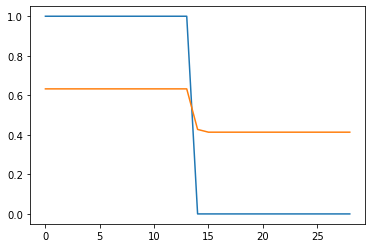

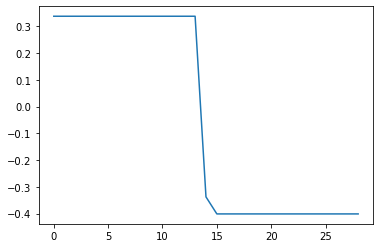

In [57]:
plt.plot(us[1:])
plt.plot(ys_predict_prob)
plt.show()
plt.plot(ws_map[:,1])